# Machine Learning Engineer Nanodegree Capstone Project
David Shahrestani  
October 22, 2016

## Overview
This notebook contains all the necessary code to create a stock trading agent with reinforcement learning and a neural network. For a more detailed explanation of every section, refer to the report pdf.

## Data Preprocessing
First, we will need to obtain our data and extract any selected features. Ideally, we would want to obtain three sets of data:
* Price Data
* Technical Indicator Data
* Fundamental Data

However, the cost of attaining an accurate historic feed of fundamental data is no laughing matter. As such, our learner will only utilize price and technical data that can be easily retrieved from the `'yahoo'` dataset provided by `pandas_datareader.data`. We will start by getting our price data and then use that to calculate our technical data.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
from datetime import datetime as dt

In [2]:
# Define functions for gathering price data

def fill_missing_values(df):
    """
    Fill missing values in data frame, in place.
    """
    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True)
    
    
def get_price_data(symbol_list, start_date, end_date):
    """
    Read stock data (adjusted close) for given symbols and time period.
    """ 
    # Initialize dataframe and index values
    df = pd.DataFrame(index=pd.date_range(start_date, end_date))
    df.index.name = "date" # name index
    
    # Add SPY for reference, if absent
    if 'SPY' not in symbol_list:
        symbol_list.insert(0, "SPY")

    # Iterate through symbols and download data
    for symbol in symbol_list:
        try:
            df_temp = pdr.DataReader(symbol, 'yahoo', start_date, end_date)
            df_temp.rename(columns = {'Adj Close': symbol}, inplace=True)
            df_temp = df_temp[symbol]                 
            df = df.join(df_temp)
            print "Downloaded ticker: {}".format(symbol)
            if symbol == "SPY":
                df = df.dropna(subset=["SPY"]) # remove none trading days
        except:
            print "Cant find ticker symbol: {}".format(symbol) # print error if not in yahoo database
            
    print "Price data downloaded for {} stocks.".format(len(symbol_list))
    
    # Fill forward, backward missing values
    fill_missing_values(df)
    
    # Split SPY data from the rest
    price_df = df
    spy_df = price_df.pop('SPY')
    
    # Export price_data and spy_data for records
    price_df.to_pickle('data/price_data.pkl')
    spy_df.to_pickle('data/spy_data.pkl')

    return price_df, spy_df

We will focus on building a stock trading agent that can implement a strategy of [sector rotation](http://www.investopedia.com/terms/s/sectorrotation.asp) - predicting which stock market sector will perform best in a given timeframe.

As a proxy for the different stock market sectors, we will use the [SPDR® Sector ETFs](https://www.spdrs.com/product/index.seam). Specifically, we will use the nine sector ETFs that have been around the longest:
* `'XLY'`: Consumer Discretionary
* `'XLP'`: Consumer Staples
* `'XLE'`: Energy
* `'XLF'`: Financials
* `'XLV'`: Health Care
* `'XLI'`: Industrial
* `'XLB'`: Materials
* `'XLK'`: Technology
* `'XLU'`: Utilities

In [3]:
# Process price data

# Initialize symbol_list
# XLP, XLE, XLF, XLV, XLI, XLB, XLK, XLU
symbol_list = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']

# Initialize start and end dates
start_date = "1999-02-01"
end_date = dt.today().strftime("%Y-%m-%d")

# Run function to get price data
price_df, spy_df = get_price_data(symbol_list, start_date, end_date)

Downloaded ticker: SPY
Downloaded ticker: XLY
Downloaded ticker: XLP
Downloaded ticker: XLE
Downloaded ticker: XLF
Downloaded ticker: XLV
Downloaded ticker: XLI
Downloaded ticker: XLB
Downloaded ticker: XLK
Downloaded ticker: XLU
Price data downloaded for 10 stocks.


In [4]:
# Explore price data
print "price_df head:\n"
print price_df.head()
print "*"*100
print "spy_df head:\n"
print spy_df.head()
print "*"*100
print "price_df summary statistics:\n"
print price_df.describe()

price_df head:

                  XLY        XLP        XLE        XLF        XLV        XLI  \
date                                                                           
1999-02-01  22.369886  18.183108  15.775198  13.232580  21.553659  17.771784   
1999-02-02  22.090579  18.332150  15.798028  13.091432  21.234164  17.634814   
1999-02-03  22.446060  18.268275  16.163300  13.188475  21.639673  17.806030   
1999-02-04  22.319103  18.183108  16.254618  12.879711  21.479929  17.828858   
1999-02-05  21.760490  17.906316  16.711208  12.773850  21.234164  17.771784   

                  XLB        XLK        XLU  
date                                         
1999-02-01  14.141692  31.116688  15.556406  
1999-02-02  14.152079  30.589936  15.349865  
1999-02-03  14.162459  30.808347  15.432480  
1999-02-04  14.577780  29.754851  15.201158  
1999-02-05  14.775061  29.035390  15.209417  
****************************************************************************************************


Now that we have our price data, we can obtain our technical data. We will be calculating:
* [simple moving averages](http://www.investopedia.com/terms/s/sma.asp)
* [bollinger bands®](http://www.investopedia.com/terms/b/bollingerbands.asp)

In [5]:
# Define functions for computing technical data

def get_simple_moving_average(price_df, window):
    """
    Returns the percentage difference between the current price and the simple
    moving average for different windows of time to be used as a technical indicator.
    """
    # Compute rolling mean
    ma = price_df.rolling(window=window).mean()
    
    # Compute distance from rolling mean
    sma_df = price_df / ma - 1
    sma_df = sma_df.fillna(value=0)
    sma_df = sma_df.round(2)
    
    return sma_df


def get_bollinger_bands(price_df, window):
    """
    Returns whether price is above or below bollinger_bands.
    1  - above upper band
    0  - inbetween bands
    -1 - below lower band
    """
    # Compute rolling mean and std    
    ma = price_df.rolling(window=window).mean()
    sd = price_df.rolling(window=window).std()
    
    # Get bands
    upper_band = ma + sd * 2
    lower_band = ma - sd * 2
    
    # Set conditional values in dataframe
    above_upper = price_df > upper_band
    below_lower = price_df < lower_band
    above_upper = above_upper.applymap(lambda x: 1.0 if x else 0.0)
    below_lower = below_lower.applymap(lambda x: 1.0 if x else 0.0)
    
    # Return dataframe
    bband_df = above_upper - below_lower
    
    return bband_df


# Function to combine techincal indicators into a single DF with tuple values
def combine_data(price_df, sma_50, sma_200, bband_50, bband_200):
    """
    Returns dataframe of tuples storing technical data for every symbol.
    """
    # Initialize new DF with same index as price_df
    new_df = pd.DataFrame(index=price_df.index) 
    
    # Iterate through column names to form a new column in a DF consisting
    # of tuples containing technical indicators
    for column in price_df:
        new_df[column] = zip(sma_50[column], sma_200[column], bband_50[column], bband_200[column])
    
    # Export techincal_data for records
    new_df.to_pickle('data/technical_data.pkl')
    
    return new_df

In [6]:
# Calculate technical data

# Calculate SMA indicator for 25 day and 100 day window
sma_25 = get_simple_moving_average(price_df, 25)
sma_100 = get_simple_moving_average(price_df, 100)

# Calculate BBAND indicator for 50 day and 200 day window
bband_50 = get_bollinger_bands(price_df, 50)
bband_200 = get_bollinger_bands(price_df, 200)

# Combine technical indicators into a single DF
tech_df = combine_data(price_df, sma_25, sma_100, bband_50, bband_200)

In [7]:
# Explore technical data
print "tech_df tail:\n"
print tech_df.ix[-10:,]

tech_df tail:

                                 XLY                       XLP  \
date                                                             
2016-10-10     (0.01, 0.0, 0.0, 0.0)  (-0.01, -0.03, 0.0, 0.0)   
2016-10-11  (-0.01, -0.01, 0.0, 0.0)  (-0.02, -0.03, 0.0, 0.0)   
2016-10-12      (0.0, 0.0, 0.0, 0.0)  (-0.01, -0.03, 0.0, 0.0)   
2016-10-13    (0.0, -0.01, 0.0, 0.0)  (-0.01, -0.03, 0.0, 0.0)   
2016-10-14    (0.0, -0.01, 0.0, 0.0)  (-0.01, -0.03, 0.0, 0.0)   
2016-10-17  (-0.01, -0.02, 0.0, 0.0)  (-0.01, -0.03, 0.0, 0.0)   
2016-10-18  (-0.01, -0.01, 0.0, 0.0)  (-0.01, -0.03, 0.0, 0.0)   
2016-10-19    (0.0, -0.01, 0.0, 0.0)  (-0.01, -0.03, 0.0, 0.0)   
2016-10-20    (0.0, -0.01, 0.0, 0.0)  (-0.01, -0.03, 0.0, 0.0)   
2016-10-21      (0.0, 0.0, 0.0, 0.0)  (-0.01, -0.03, 0.0, 0.0)   

                               XLE                     XLF  \
date                                                         
2016-10-10  (0.04, 0.06, 0.0, 0.0)  (0.02, 0.04, 0.0, 0.0)   
2016-1

## Implementation

Next, we will build our Q-learning agent. We can break this section down into three steps:
1. Create a function to manage data loading for different training and testing periods.
2. Create a portfolio class to keep track of our models performance.
3. Create an evaluation function to test our model on the testing set at the end of each epoch.
4. Design our Q-learning functions (state, action, reward, new state).
5. Build the Q-function out of a neural net. This will map states to rewards.
6. Train and test in a Q-learning loop.

In [8]:
# 1. Create a function to manage data loading for different training and testing periods.

def load_data(window=201, test=False):
    """
    Load training and test sets. Use after data has been preprocessed and
    exported. Window sets the start date. Always use one year of training data
    followed by one month of testing data.
    """ 
    # Load data
    prices = pd.read_pickle('data/price_data.pkl')
    spy = pd.read_pickle('data/spy_data.pkl')
    tech = pd.read_pickle('data/technical_data.pkl')
    
    # Set date variables
    test_win = 175
    train_win = 25
    start = window
    t_start = window - test_win
    end = window - test_win - train_win
    
    # Subset training data
    prices_train = prices.iloc[-start:-t_start,]
    tech_train = tech.iloc[-start:-t_start,]
    spy_train = spy.iloc[-start:-t_start,]

    # Subset testing data
    prices_test = prices.iloc[-t_start:-end,]
    tech_test = tech.iloc[-t_start:-end,]
    spy_test = spy.iloc[-t_start:-end,]

    # Return dataset
    if test == True:
        return tech_test, prices_test, spy_test
    else:
        return tech_train, prices_train, spy_train

In [9]:
# 2. Create a portfolio class to keep track of our models performance.

# Create helper functions
def normalize_data(df):
    """
    Normalize stock prices using the first row of dataframe.
    """
    return df / df.ix[0, :]


def plot_data(df, epoch, title="Stock prices", xlabel="Date", ylabel="Price",
              legend=True, test=0):
    """
    Plot stock prices with a custom title and axis labels. Export plots to file
    based on epoch given a dataframe.
    """
    # Initalize plot
    ax = df.plot(title=title, fontsize=9, figsize=(11, 8))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if legend:
        ax.legend(loc='best')

    # Save plot to file (plots folder must exist)
    if test == 0:
        plt.savefig('plots/train_plot_{}.png'.format(epoch))
    elif test == 1:
        plt.savefig('plots/test_plot_{}.png'.format(epoch))
    else:
        plt.savefig('plots/eval_plot_{}.png'.format(epoch))
        plt.show()
    
    # Close plots to save memory
    plt.close('all')
    

# Create portfolio class
class Portfolio(object):
    def __init__(self, initial_value, df_price):
        # Initial value of portfolio and time_step 1
        self.initial_value = initial_value
        
        # Dataframe to track portfolio throughout learning and testing
        self.port_tracker = pd.DataFrame(index=df_price.index)
        self.port_tracker['value'] = np.nan
        self.port_tracker['value'][0] = initial_value
        
        
    def get_value(self, price_data, weights, time_step):
        """
        Returns the value of a constant portfolio on a given day.
        Used to calculate return between different time periods and weights.
        """
        # Get prices and normalize them
        norm_price = normalize_data(price_data)
    
        # Multiply normalized prices by portfolio weights
        alloced = norm_price * weights
        
        # Multiple eighted portfolio by initial value        
        pos_vals = alloced * self.initial_value
    
        # Sum accross position values to get portfolio value
        port_val = pos_vals.sum(axis=1)
        
        # Get time period that we are on
        port_val = port_val[time_step-1]
    
        return port_val
    
        
    def statistics(self, benchmark, samples_per_year=252, riskfree=.02): 
        """
        Calculate statistics on given portfolio of symbols given a benchmark.
        cum_ret, avg_daily_ret, std_daily_ret, sharpe_ratio
        """
        # First get daily returns on portfolio    
        daily_ret = (self.port_tracker['value'] /
                     self.port_tracker['value'].shift(1)) - 1
        daily_ret.ix[0] = 0 # set daily returns for row 0 to 0
        daily_ret = daily_ret.ix[1:] #drop first value, it is NaN
        
        # Compute portfolio statistics
        cum_ret = (self.port_tracker['value'][-2] /
                   self.port_tracker['value'][0]) - 1
        avg_daily_ret = daily_ret.mean()
        std_daily_ret = daily_ret.std()
        k = np.sqrt(samples_per_year)
        adj_risk_free = np.power((1 + riskfree), (1 / samples_per_year)) - 1
        sharpe_ratio = k * ((avg_daily_ret - adj_risk_free) / std_daily_ret)
        
        # Compute benchmark daily returns
        daily_ret_spy = (benchmark / benchmark.shift(1)) - 1
        daily_ret_spy.ix[0] = 0 # set daily returns for row 0 to 0
        daily_ret_spy = daily_ret_spy.ix[1:] #drop first value, it is NaN
        
        # Compute benchmark statistics        
        avg_spy_ret = daily_ret_spy.mean()
        std_spy_ret = daily_ret_spy.std()
        sharpe_ratio_spy = k * ((avg_spy_ret - adj_risk_free) / std_spy_ret)
        cum_spy = (benchmark[-2] / benchmark[0]) - 1
    
        return cum_ret, sharpe_ratio, cum_spy, sharpe_ratio_spy
    
        
    def plot_results(self, benchmark, epoch, test=0):
        """
        Plot portfolio results and compare them with benchmark.
        """
        # Combine benchmark and portfolio data
        df_temp = pd.concat([self.port_tracker, benchmark[:-1]], axis=1)
        df_temp.rename(columns = {0: 'PORT_VAL'}, inplace=True)
        
        # Plot
        if test == 0:
            plot_data(normalize_data(df_temp), epoch,
                      title="Daily Portfolio and SPY value (train: {})".format(epoch),
                      xlabel="Date", ylabel="Value", test=test)
        else:
            plot_data(normalize_data(df_temp), epoch,
                      title="Daily Portfolio and SPY value (test: {})".format(epoch),
                      xlabel="Date", ylabel="Value", test=test)

In [10]:
# 3. Create an evaluation function to test our model on the testing set at the end of each epoch.

def evaluate_qlearner(test_data, model, test_price, test_spy, epoch):
    """
    Evaluate the performance of the learner at each epoch. Returns statistics
    and saves a log of actions and a plot of performance.
    """
    state = init_state(test_data)
    status = 1
    terminal_state = 0
    time_step = 1
    port_test = Portfolio(100000, test_price)
    open('logs/test_action_log_{}.txt'.format(epoch+1), 'w').close()

    while(status == 1):
        # Run Q-function model on initial state and get rewards for actions
        qval = model.predict(state[0], batch_size=1)

        # Get action from qval
        action = (np.argmax(qval))

        # Take action and get new state
        new_state, time_step, terminal_state = take_action(state, test_data,
                                                           action, time_step)
        
        # Get reward
        reward = get_reward(port_test, test_price, state, new_state, time_step)
        
        # Update state
        state = new_state
        
        # Update status
        if terminal_state == 1: #terminal state
            status = 0
            
        # Log date, actions, and reward to text file. (logs folder must exist)
        date = test_price.iloc[time_step - 1].name
        with open('logs/test_action_log_{}.txt'.format(epoch+1), 'a') as file:
            file.write("{} ACTION: {} ({:.3f})\n".format(date, action, reward))
    
    # Extract statistics on test and save plot            
    cum_ret, sharpe_ratio, cum_spy, sharpe_ratio_spy = port_test.statistics(test_spy)
    port_test.plot_results(test_spy, epoch+1, test=1)
    
    return cum_ret, sharpe_ratio, cum_spy, sharpe_ratio_spy

In [11]:
# 4. Design our Q-learning functions (state, action, reward, new state).

def init_state(tech_data):
    """
    Get the initial state for our Qlearner. State holds technical data and the
    current portfolio weights.
    """
    # Intialize weights to be even across portfolio
    init_weight_guess = np.ones(tech_data.shape[1],
                                dtype=np.float64) * 1.0 / tech_data.shape[1]
    
    # State will hold our technical data and the current portfolio weights
    state = [np.array([[np.array(tech_data.ix[0,:].values,
                                 dtype=('f4,f4,i4,i4'))]]), init_weight_guess]
    
    return state


def take_action(state, tech_data, action, time_step):
    """
    Executes an action (0-9) by mapping it to a weight. Actions are limited to
    overweighting one sector or holding all sectors equally.
    """
    # Increase time_step
    time_step += 1
    
    # Map actions to portfolio weights
    if action == 0:
        weight = np.array([0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11])
    elif action == 1:
        weight = np.array([0.28,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09])
    elif action == 2:
        weight = np.array([0.09,0.28,0.09,0.09,0.09,0.09,0.09,0.09,0.09])
    elif action == 3:
        weight = np.array([0.09,0.09,0.28,0.09,0.09,0.09,0.09,0.09,0.09])
    elif action == 4:
        weight = np.array([0.09,0.09,0.09,0.28,0.09,0.09,0.09,0.09,0.09])
    elif action == 5:
        weight = np.array([0.09,0.09,0.09,0.09,0.28,0.09,0.09,0.09,0.09])
    elif action == 6:
        weight = np.array([0.09,0.09,0.09,0.09,0.09,0.28,0.09,0.09,0.09])
    elif action == 7:
        weight = np.array([0.09,0.09,0.09,0.09,0.09,0.09,0.28,0.09,0.09])
    elif action == 8:
        weight = np.array([0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.28,0.09])
    else:
        weight = np.array([0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.28])
    
    # Set termenal state to 1 if this is the last time_step
    if time_step + 1 == tech_data.shape[0]:
        terminal_state = 1
    else:
        terminal_state = 0

    # Set the new states technical data and weights and return t
    new_state = [np.array([[np.array(tech_data.ix[time_step-1,:].values,
                                     dtype=('f4,f4,i4,i4'))]]), weight]

    return new_state, time_step, terminal_state

    
def get_reward(port, price_data, initial_state, new_state, time_step):
    """
    Gets reward based on difference in value between initial_state and
    new_state. Updates portfolio tracker with values.
    """
    # Calculate percent change from initial_state to _new_state
    value_new = port.get_value(price_data, new_state[1], time_step)
    value_init = port.get_value(price_data, initial_state[1], time_step-1)    
    reward = (value_new / value_init) - 1
    
    # Update portfolio tracker
    port.port_tracker['value'][time_step-1] = port.port_tracker['value'][time_step - 2] * (reward + 1)

    # Using portfolio tracker values, set reward to be the cummulative return
    # Over a 20 day window. Otherwise since inception. 
    if time_step < 20:
        reward = (port.port_tracker['value'][time_step-1] /
                  port.port_tracker['value'][0])-1
        # Modify reward to weight gains and losses differently
        if reward > 0:
            reward = (reward + 1)
        else:
            reward = (reward - 1)**3
    else:
        reward = (port.port_tracker['value'][time_step-1] /
                  port.port_tracker['value'][time_step-20])-1
        # Modify reward to weight gains and losses differently
        if reward > 0:
            reward = (reward + 1)
        else:
            reward = (reward - 1)**3

    return reward

In [12]:
# 5. Build the Q-function out of a neural net. This will map states to rewards.

# Import libraries
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam

# Set dimension variables
st_dim = init_state(pd.read_pickle('data/technical_data.pkl'))
st_dim = st_dim[0]
steps = st_dim.shape[1]
num_features = st_dim.shape[2]

# Initialize sequential model
model = Sequential()

# Build first layer
model.add(LSTM(64,
               input_shape=(steps, num_features),
               return_sequences=True,
               stateful=False))
model.add(Dropout(0.50)) # drop inputs to avoid overfitting

# Build second layer
model.add(LSTM(64,
               input_shape=(steps, num_features),
               return_sequences=True,
               stateful=False))
model.add(Dropout(0.50)) # drop inputs to avoid overfitting

# Build third layer
model.add(LSTM(64,
               input_shape=(steps, num_features),
               return_sequences=False,
               stateful=False))
model.add(Dropout(0.50)) # drop inputs to avoid overfitting

# Build fourth layer
model.add(Dense(10, init='lecun_uniform'))
model.add(Activation('linear'))

# Build optimizer and compile
adam = Adam()
model.compile(loss='mse', optimizer=adam)

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)


In [13]:
# 6. Train and test in a Q-learning loop.
# Model will be fed batches of an experience replay to be trained on.

# Import Libraries
import random
import timeit

# Initialize start time
start_time = timeit.default_timer()

# Initialize learning variables
epochs = 25 # number of passes on the training data
gamma = 0.95 # weight of future rewards
epsilon = 1.25 # measure of randomness for exploration (ten random epochs then constant decrease)
batch_size = 10 # size of training batches for our neural net

# Initialize experience variables
memory = [] # stores training data for neural net in efficient chunks
mem_limit = 20
mem_counter = 0

# Initialize training window start
window = 201

# Initialize testing data
test_data, test_price, test_spy = load_data(window=window, test=True)

# Initialize training data
train_data, price_data, benchmark = load_data(window=window)

# Open file to log portfolio results after epoch (logs folder must exist)
open('logs/master_test_log.txt', 'w').close()
open('logs/master_train_log.txt', 'w').close()

for i in range(epochs):
    # Initialize variables
    state = init_state(train_data)
    port = Portfolio(100000, price_data)
    status = 1
    terminal_state = 0
    time_step = 1
    
    # Open file to log training actions (logs folder must exist)
    open('logs/train_action_log_{}.txt'.format(i+1), 'w').close()
    
    # Train while status = 1
    while status == 1:
        # Run Q-function model on initial state and get rewards for actions
        qval = model.predict(state[0], batch_size=1)
        
        # Using epsilon, add random exporation to the trainer
        # Otherwise find action with Q-function model.
        if random.random() < epsilon:
            action = np.random.randint(1,10)
        else:
            action = (np.argmax(qval))
            
        # Take action and get new state
        new_state, time_step, terminal_state = take_action(state, train_data, action, time_step)
        
        # Get reward
        reward = get_reward(port, price_data, state, new_state, time_step)
        
        # Log date, actions, and reward to text file. (logs folder must exist)
        date = price_data.iloc[time_step - 1].name
        with open('logs/train_action_log_{}.txt'.format(i+1), 'a') as file:
                file.write("{} ACTION: {} ({:.3f})\n".format(date, action, reward))
        
        # If memory not full, add to memory
        if len(memory) < mem_limit:
            memory.append((state, action, reward, new_state))
            state = new_state # set state for next loop
            
        # Otherwise overwrite memory
        else:
            if mem_counter < (mem_limit - 1):
                mem_counter +=1
            else:
                mem_counter = 0
            memory[mem_counter] = (state, action, reward, new_state)
            state = new_state # set state for next loop
            
            # Begin training model on memory experience
            mem_batch = random.sample(memory, batch_size)
            X_train = []
            y_train = []

            for mem in mem_batch:
                # Get Q-values with Q-function
                prior_state, action, reward, next_state = mem
                prior_qval = model.predict(prior_state[0], batch_size=1)
                next_qval = model.predict(next_state[0], batch_size=1)
                
                # Get reward for next state
                next_reward = np.max(next_qval)
                
                # Calculate reward based on gamma, if terminal just use reward
                if terminal_state == 0:
                    reward_update = (reward + (gamma * next_reward))
                else: #terminal state
                    reward_update = reward
                    
                # Get training data together
                y = np.zeros((1,10))
                y[:] = prior_qval[:]
                y[0][action] = reward_update

                X_train.append(prior_state[0]) # Input technical data
                y_train.append(y.reshape(10,)) # Output reward for actions
                
            # Reshape training batch to fit model input
            X_train = np.squeeze(np.array(X_train), axis=(1))
            y_train = np.array(y_train)
            
            # Train model on memory batch
            model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1, verbose=0)

        # update status
        if terminal_state == 1:
            status = 0
            
    # Update epsilon for next epoch
    epsilon -= (1.25/(epochs-1))
            
    # Evaluate epoch results on training data
    cum_ret, sharpe_ratio, cum_spy, sharpe_ratio_spy = port.statistics(benchmark)
    port.plot_results(benchmark, i+1)
    with open('logs/master_train_log.txt'.format(i+1), 'a') as file:
                file.write("Train {}/{}: Relative Return/Sharpe: {:.4%}/{:.2f}\n".format(i+1, epochs,
                                                                                         cum_ret - cum_spy,
                                                                                         sharpe_ratio - sharpe_ratio_spy))
                
    # Evaluate epoch results on testing data
    elapsed = np.round((timeit.default_timer() - start_time)/60, decimals=2)
    cum_ret, sharpe_ratio, cum_spy, sharpe_ratio_spy = evaluate_qlearner(test_data, model, test_price, test_spy, i)
    print "Test {}/{} completed in {:.2f} minutes - Relative Return/Sharpe: {:.4%} / {:.2f}".format(i+1, epochs, elapsed,
                                                                                                    cum_ret - cum_spy,
                                                                                                    sharpe_ratio - \
                                                                                                    sharpe_ratio_spy)
    with open('logs/master_test_log.txt'.format(i+1), 'a') as file:
                file.write("Test {}/{}: Relative Return/Sharpe: {:.4%}/{:.2f}\n".format(i+1, epochs, cum_ret - cum_spy,
                                                                                        sharpe_ratio - sharpe_ratio_spy))
    #print "*"*100
    
elapsed = np.round((timeit.default_timer() - start_time)/60/60, decimals=2)
print "Epochs completed in {:.2f} hours".format(elapsed)

Test 1/25 completed in 0.72 minutes - Relative Return/Sharpe: -0.3751% / -0.21
Test 2/25 completed in 1.06 minutes - Relative Return/Sharpe: -0.3751% / -0.21
Test 3/25 completed in 1.40 minutes - Relative Return/Sharpe: -0.3751% / -0.21
Test 4/25 completed in 1.73 minutes - Relative Return/Sharpe: 0.1376% / 0.32
Test 5/25 completed in 2.07 minutes - Relative Return/Sharpe: 0.1376% / 0.32
Test 6/25 completed in 2.42 minutes - Relative Return/Sharpe: -0.3751% / -0.21
Test 7/25 completed in 2.76 minutes - Relative Return/Sharpe: 0.4591% / 0.65
Test 8/25 completed in 3.10 minutes - Relative Return/Sharpe: 0.2498% / 0.47
Test 9/25 completed in 3.44 minutes - Relative Return/Sharpe: 0.2498% / 0.47
Test 10/25 completed in 3.77 minutes - Relative Return/Sharpe: 0.9153% / 1.02
Test 11/25 completed in 4.11 minutes - Relative Return/Sharpe: 0.9153% / 1.02
Test 12/25 completed in 4.45 minutes - Relative Return/Sharpe: 0.9153% / 1.02
Test 13/25 completed in 4.80 minutes - Relative Return/Sharpe: 0.

## Evaluation

Now, let's take a look our test results for the last epoch (found in logs under '2016-09-19') and see how we did.

Our model's total return for the period outperformed the benchmark by 0.9153%. Its Sharpe ratio outperformed the benchmark by 1.02. Let's take a look at the actions that our model chose and see how well it compares to other actions it could have taken.

> 2016-09-19 00:00:00 ACTION: 3 (1.001)  
2016-09-20 00:00:00 ACTION: 3 (-1.002)  
2016-09-21 00:00:00 ACTION: 3 (1.014)  
2016-09-22 00:00:00 ACTION: 3 (1.019)  
2016-09-23 00:00:00 ACTION: 3 (1.012)  
2016-09-26 00:00:00 ACTION: 3 (1.005)  
2016-09-27 00:00:00 ACTION: 3 (1.006)  
2016-09-28 00:00:00 ACTION: 3 (1.020)  
2016-09-29 00:00:00 ACTION: 3 (1.012)  
2016-09-30 00:00:00 ACTION: 3 (1.021)  
2016-10-03 00:00:00 ACTION: 3 (1.019)  
2016-10-04 00:00:00 ACTION: 3 (1.010)  
2016-10-05 00:00:00 ACTION: 3 (1.018)  
2016-10-06 00:00:00 ACTION: 3 (1.020)  
2016-10-07 00:00:00 ACTION: 3 (1.014)  
2016-10-10 00:00:00 ACTION: 3 (1.022)  
2016-10-11 00:00:00 ACTION: 3 (1.009)  
2016-10-12 00:00:00 ACTION: 3 (1.010)  
2016-10-13 00:00:00 ACTION: 3 (1.007)  
2016-10-14 00:00:00 ACTION: 3 (1.004)  
2016-10-17 00:00:00 ACTION: 3 (1.003)  
2016-10-18 00:00:00 ACTION: 3 (-1.018)  
2016-10-19 00:00:00 ACTION: 3 (-1.016)  

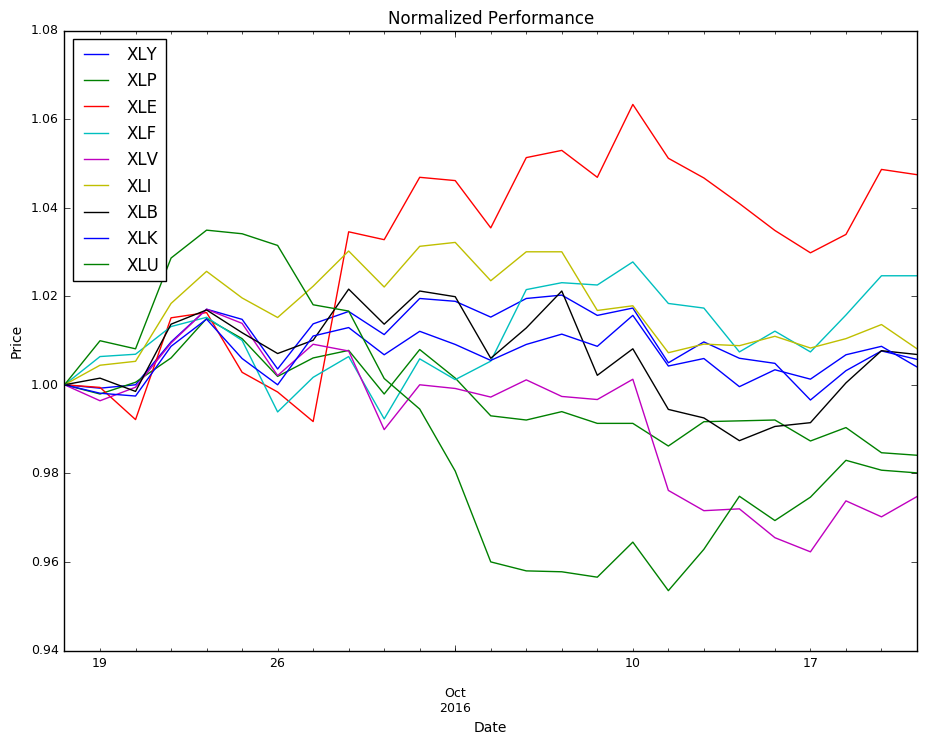

In [17]:
%matplotlib inline

df = test_price
plot_data(normalize_data(df), "train", title="Normalized Performance", test=3)

## Further cross-validation

It looks like our model successfully picked the best performing sector (Action 3: `'XLE'`) for the period September 19 - October 19. These results are nice, but they could also be specific to the time period. Cross-validation can be problematic with time-series data since a pattern can emerge in one year and disappear in the next. To really know how well our model generalizes, we will need to train it on other training and testing windows.

I found rolling cross-validation to be too costly for our purposes, but it would be useful in finding the ideal training window given better hardware. Instead, I will simply implement our Q-learner on a random start date between now and the late 1990's. I will then evaluate the model in the same way as above and repeat.

In [18]:
# Re-initialize and run Q-learning loop on random time window (Same code as above)

# Neural Net Q-Function
# Initialize sequential model
model = Sequential()

# Build first layer
model.add(LSTM(64,
               input_shape=(steps, num_features),
               return_sequences=True,
               stateful=False))
model.add(Dropout(0.50)) # drop inputs to avoid overfitting

# Build second layer
model.add(LSTM(64,
               input_shape=(steps, num_features),
               return_sequences=True,
               stateful=False))
model.add(Dropout(0.50)) # drop inputs to avoid overfitting

# Build third layer
model.add(LSTM(64,
               input_shape=(steps, num_features),
               return_sequences=False,
               stateful=False))
model.add(Dropout(0.50)) # drop inputs to avoid overfitting

# Build fourth layer
model.add(Dense(10, init='lecun_uniform'))
model.add(Activation('linear'))

# Build optimizer and compile
adam = Adam()
model.compile(loss='mse', optimizer=adam)

# Q-Learning loop
# Initialize start time
start_time = timeit.default_timer()

# Initialize learning variables
epochs = 25 # number of passes on the training data
gamma = 0.95 # weight of future rewards
epsilon = 1.25 # measure of randomness for exploration (ten random epochs then constant decrease)
batch_size = 10 # size of training batches for our neural net

# Initialize experience variables
memory = [] # stores training data for neural net in efficient chunks
mem_limit = 20
mem_counter = 0

# Initialize random training window start
window = np.random.randint(201,4000)
print "Window: {}".format(window)

# Initialize testing data
test_data, test_price, test_spy = load_data(window=window, test=True)

# Initialize training data
train_data, price_data, benchmark = load_data(window=window)

# Open file to log portfolio results after epoch (logs folder must exist)
open('logs/master_test_log.txt', 'w').close()
open('logs/master_train_log.txt', 'w').close()

for i in range(epochs):
    # Initialize variables
    state = init_state(train_data)
    port = Portfolio(100000, price_data)
    status = 1
    terminal_state = 0
    time_step = 1
    
    # Open file to log training actions (logs folder must exist)
    open('logs/train_action_log_{}.txt'.format(i+1), 'w').close()
    
    # Train while status = 1
    while status == 1:
        # Run Q-function model on initial state and get rewards for actions
        qval = model.predict(state[0], batch_size=1)
        
        # Using epsilon, add random exporation to the trainer
        # Otherwise find action with Q-function model.
        if random.random() < epsilon:
            action = np.random.randint(1,10)
        else:
            action = (np.argmax(qval))
            
        # Take action and get new state
        new_state, time_step, terminal_state = take_action(state, train_data, action, time_step)
        
        # Get reward
        reward = get_reward(port, price_data, state, new_state, time_step)
        
        # Log date, actions, and reward to text file. (logs folder must exist)
        date = price_data.iloc[time_step - 1].name
        with open('logs/train_action_log_{}.txt'.format(i+1), 'a') as file:
                file.write("{} ACTION: {} ({:.3f})\n".format(date, action, reward))
        
        # If memory not full, add to memory
        if len(memory) < mem_limit:
            memory.append((state, action, reward, new_state))
            state = new_state # set state for next loop
            
        # Otherwise overwrite memory
        else:
            if mem_counter < (mem_limit - 1):
                mem_counter +=1
            else:
                mem_counter = 0
            memory[mem_counter] = (state, action, reward, new_state)
            state = new_state # set state for next loop
            
            # Begin training model on memory experience
            mem_batch = random.sample(memory, batch_size)
            X_train = []
            y_train = []

            for mem in mem_batch:
                # Get Q-values with Q-function
                prior_state, action, reward, next_state = mem
                prior_qval = model.predict(prior_state[0], batch_size=1)
                next_qval = model.predict(next_state[0], batch_size=1)
                
                # Get reward for next state
                next_reward = np.max(next_qval)
                
                # Calculate reward based on gamma, if terminal just use reward
                if terminal_state == 0:
                    reward_update = (reward + (gamma * next_reward))
                else: #terminal state
                    reward_update = reward
                    
                # Get training data together
                y = np.zeros((1,10))
                y[:] = prior_qval[:]
                y[0][action] = reward_update

                X_train.append(prior_state[0]) # Input technical data
                y_train.append(y.reshape(10,)) # Output reward for actions
                
            # Reshape training batch to fit model input
            X_train = np.squeeze(np.array(X_train), axis=(1))
            y_train = np.array(y_train)
            
            # Train model on memory batch
            model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1, verbose=0)

        # update status
        if terminal_state == 1:
            status = 0
            
    # Update epsilon for next epoch
    epsilon -= (1.25/(epochs-1))
            
    # Evaluate epoch results on training data
    cum_ret, sharpe_ratio, cum_spy, sharpe_ratio_spy = port.statistics(benchmark)
    port.plot_results(benchmark, i+1)
    with open('logs/master_train_log.txt'.format(i+1), 'a') as file:
                file.write("Train {}/{}: Relative Return/Sharpe: {:.4%}/{:.2f}\n".format(i+1, epochs,
                                                                                         cum_ret - cum_spy,
                                                                                         sharpe_ratio - sharpe_ratio_spy))
                
    # Evaluate epoch results on testing data
    elapsed = np.round((timeit.default_timer() - start_time)/60, decimals=2)
    cum_ret, sharpe_ratio, cum_spy, sharpe_ratio_spy = evaluate_qlearner(test_data, model, test_price, test_spy, i)
    print "Test {}/{} completed in {:.2f} minutes - Relative Return/Sharpe: {:.4%} / {:.2f}".format(i+1, epochs, elapsed,
                                                                                                    cum_ret - cum_spy,
                                                                                                    sharpe_ratio - \
                                                                                                    sharpe_ratio_spy)
    with open('logs/master_test_log.txt'.format(i+1), 'a') as file:
                file.write("Test {}/{}: Relative Return/Sharpe: {:.4%}/{:.2f}\n".format(i+1, epochs, cum_ret - cum_spy,
                                                                                        sharpe_ratio - sharpe_ratio_spy))
    #print "*"*100
    
elapsed = np.round((timeit.default_timer() - start_time)/60/60, decimals=2)
print "Epochs completed in {:.2f} hours".format(elapsed)

Window: 3354
Test 1/25 completed in 0.78 minutes - Relative Return/Sharpe: 0.0404% / -0.12
Test 2/25 completed in 1.13 minutes - Relative Return/Sharpe: 0.0404% / -0.12
Test 3/25 completed in 1.44 minutes - Relative Return/Sharpe: -0.7066% / -0.65
Test 4/25 completed in 1.79 minutes - Relative Return/Sharpe: -0.7066% / -0.65
Test 5/25 completed in 2.13 minutes - Relative Return/Sharpe: 0.2840% / 0.07
Test 6/25 completed in 2.48 minutes - Relative Return/Sharpe: -0.2799% / -0.34
Test 7/25 completed in 2.82 minutes - Relative Return/Sharpe: 0.2840% / 0.08
Test 8/25 completed in 3.17 minutes - Relative Return/Sharpe: 0.2840% / 0.08
Test 9/25 completed in 3.50 minutes - Relative Return/Sharpe: 0.2840% / 0.08
Test 10/25 completed in 3.82 minutes - Relative Return/Sharpe: 0.2840% / 0.08
Test 11/25 completed in 4.13 minutes - Relative Return/Sharpe: 0.2840% / 0.08
Test 12/25 completed in 4.47 minutes - Relative Return/Sharpe: 0.2840% / 0.08
Test 13/25 completed in 4.81 minutes - Relative Retu

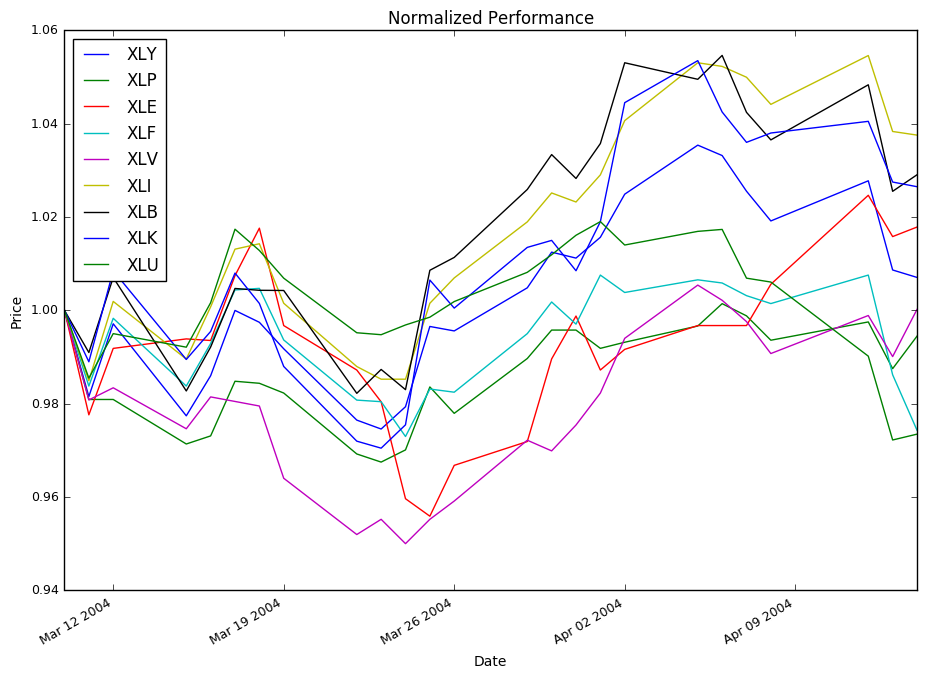

In [19]:
df = test_price
plot_data(normalize_data(df), "train", title="Normalized Performance", test=3)

Let's take a look our test results for the last epoch (found in logs under '2004-03-11') and see how we did.

Our model's total return for the period outperformed the benchmark by 0.2840%. Its Sharpe ratio outperformed the benchmark by 0.08. Let's take a look at the actions that our model chose and see how well it compares to other actions it could have taken (shown in the graph above):

> 2004-03-11 00:00:00 ACTION: 6 (-1.048)  
2004-03-12 00:00:00 ACTION: 6 (-1.009)  
2004-03-15 00:00:00 ACTION: 6 (-1.046)  
2004-03-16 00:00:00 ACTION: 6 (-1.022)  
2004-03-17 00:00:00 ACTION: 6 (1.004)  
2004-03-18 00:00:00 ACTION: 6 (1.004)  
2004-03-19 00:00:00 ACTION: 6 (-1.018)  
2004-03-22 00:00:00 ACTION: 6 (-1.061)  
2004-03-23 00:00:00 ACTION: 6 (-1.065)  
2004-03-24 00:00:00 ACTION: 6 (-1.071)  
2004-03-25 00:00:00 ACTION: 6 (-1.029)  
2004-03-26 00:00:00 ACTION: 6 (-1.022)  
2004-03-29 00:00:00 ACTION: 6 (1.004)  
2004-03-30 00:00:00 ACTION: 6 (1.010)  
2004-03-31 00:00:00 ACTION: 6 (1.009)  
2004-04-01 00:00:00 ACTION: 6 (1.013)  
2004-04-02 00:00:00 ACTION: 6 (1.022)  
2004-04-05 00:00:00 ACTION: 6 (1.029)  
2004-04-06 00:00:00 ACTION: 6 (1.028)  
2004-04-07 00:00:00 ACTION: 6 (1.040)  
2004-04-08 00:00:00 ACTION: 6 (1.024)  
2004-04-12 00:00:00 ACTION: 6 (1.043)  
2004-04-13 00:00:00 ACTION: 6 (1.019)  

Once again, our model successfully chose the sector that performed best in the period (Action 6: `'XLI'`). Let's try it again with another random period.

In [20]:
# Re-initialize and run Q-learning loop on random time window (Same code as above)

# Neural Net Q-Function
# Initialize sequential model
model = Sequential()

# Build first layer
model.add(LSTM(64,
               input_shape=(steps, num_features),
               return_sequences=True,
               stateful=False))
model.add(Dropout(0.50)) # drop inputs to avoid overfitting

# Build second layer
model.add(LSTM(64,
               input_shape=(steps, num_features),
               return_sequences=True,
               stateful=False))
model.add(Dropout(0.50)) # drop inputs to avoid overfitting

# Build third layer
model.add(LSTM(64,
               input_shape=(steps, num_features),
               return_sequences=False,
               stateful=False))
model.add(Dropout(0.50)) # drop inputs to avoid overfitting

# Build fourth layer
model.add(Dense(10, init='lecun_uniform'))
model.add(Activation('linear'))

# Build optimizer and compile
adam = Adam()
model.compile(loss='mse', optimizer=adam)

# Q-Learning loop
# Initialize start time
start_time = timeit.default_timer()

# Initialize learning variables
epochs = 25 # number of passes on the training data
gamma = 0.95 # weight of future rewards
epsilon = 1.25 # measure of randomness for exploration (ten random epochs then constant decrease)
batch_size = 10 # size of training batches for our neural net

# Initialize experience variables
memory = [] # stores training data for neural net in efficient chunks
mem_limit = 20
mem_counter = 0

# Initialize random training window start
window = np.random.randint(201,4000)
print "Window: {}".format(window)

# Initialize testing data
test_data, test_price, test_spy = load_data(window=window, test=True)

# Initialize training data
train_data, price_data, benchmark = load_data(window=window)

# Open file to log portfolio results after epoch (logs folder must exist)
open('logs/master_test_log.txt', 'w').close()
open('logs/master_train_log.txt', 'w').close()

for i in range(epochs):
    # Initialize variables
    state = init_state(train_data)
    port = Portfolio(100000, price_data)
    status = 1
    terminal_state = 0
    time_step = 1
    
    # Open file to log training actions (logs folder must exist)
    open('logs/train_action_log_{}.txt'.format(i+1), 'w').close()
    
    # Train while status = 1
    while status == 1:
        # Run Q-function model on initial state and get rewards for actions
        qval = model.predict(state[0], batch_size=1)
        
        # Using epsilon, add random exporation to the trainer
        # Otherwise find action with Q-function model.
        if random.random() < epsilon:
            action = np.random.randint(1,10)
        else:
            action = (np.argmax(qval))
            
        # Take action and get new state
        new_state, time_step, terminal_state = take_action(state, train_data, action, time_step)
        
        # Get reward
        reward = get_reward(port, price_data, state, new_state, time_step)
        
        # Log date, actions, and reward to text file. (logs folder must exist)
        date = price_data.iloc[time_step - 1].name
        with open('logs/train_action_log_{}.txt'.format(i+1), 'a') as file:
                file.write("{} ACTION: {} ({:.3f})\n".format(date, action, reward))
        
        # If memory not full, add to memory
        if len(memory) < mem_limit:
            memory.append((state, action, reward, new_state))
            state = new_state # set state for next loop
            
        # Otherwise overwrite memory
        else:
            if mem_counter < (mem_limit - 1):
                mem_counter +=1
            else:
                mem_counter = 0
            memory[mem_counter] = (state, action, reward, new_state)
            state = new_state # set state for next loop
            
            # Begin training model on memory experience
            mem_batch = random.sample(memory, batch_size)
            X_train = []
            y_train = []

            for mem in mem_batch:
                # Get Q-values with Q-function
                prior_state, action, reward, next_state = mem
                prior_qval = model.predict(prior_state[0], batch_size=1)
                next_qval = model.predict(next_state[0], batch_size=1)
                
                # Get reward for next state
                next_reward = np.max(next_qval)
                
                # Calculate reward based on gamma, if terminal just use reward
                if terminal_state == 0:
                    reward_update = (reward + (gamma * next_reward))
                else: #terminal state
                    reward_update = reward
                    
                # Get training data together
                y = np.zeros((1,10))
                y[:] = prior_qval[:]
                y[0][action] = reward_update

                X_train.append(prior_state[0]) # Input technical data
                y_train.append(y.reshape(10,)) # Output reward for actions
                
            # Reshape training batch to fit model input
            X_train = np.squeeze(np.array(X_train), axis=(1))
            y_train = np.array(y_train)
            
            # Train model on memory batch
            model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1, verbose=0)

        # update status
        if terminal_state == 1:
            status = 0
            
    # Update epsilon for next epoch
    epsilon -= (1.25/(epochs-1))
            
    # Evaluate epoch results on training data
    cum_ret, sharpe_ratio, cum_spy, sharpe_ratio_spy = port.statistics(benchmark)
    port.plot_results(benchmark, i+1)
    with open('logs/master_train_log.txt'.format(i+1), 'a') as file:
                file.write("Train {}/{}: Relative Return/Sharpe: {:.4%}/{:.2f}\n".format(i+1, epochs,
                                                                                         cum_ret - cum_spy,
                                                                                         sharpe_ratio - sharpe_ratio_spy))
                
    # Evaluate epoch results on testing data
    elapsed = np.round((timeit.default_timer() - start_time)/60, decimals=2)
    cum_ret, sharpe_ratio, cum_spy, sharpe_ratio_spy = evaluate_qlearner(test_data, model, test_price, test_spy, i)
    print "Test {}/{} completed in {:.2f} minutes - Relative Return/Sharpe: {:.4%} / {:.2f}".format(i+1, epochs, elapsed,
                                                                                                    cum_ret - cum_spy,
                                                                                                    sharpe_ratio - \
                                                                                                    sharpe_ratio_spy)
    with open('logs/master_test_log.txt'.format(i+1), 'a') as file:
                file.write("Test {}/{}: Relative Return/Sharpe: {:.4%}/{:.2f}\n".format(i+1, epochs, cum_ret - cum_spy,
                                                                                        sharpe_ratio - sharpe_ratio_spy))
    #print "*"*100
    
elapsed = np.round((timeit.default_timer() - start_time)/60/60, decimals=2)
print "Epochs completed in {:.2f} hours".format(elapsed)

Window: 2831
Test 1/25 completed in 0.72 minutes - Relative Return/Sharpe: 0.7919% / 2.39
Test 2/25 completed in 1.05 minutes - Relative Return/Sharpe: -0.3267% / 1.03
Test 3/25 completed in 1.37 minutes - Relative Return/Sharpe: 1.2206% / 2.71
Test 4/25 completed in 1.72 minutes - Relative Return/Sharpe: 1.2206% / 2.71
Test 5/25 completed in 2.06 minutes - Relative Return/Sharpe: 0.7919% / 2.39
Test 6/25 completed in 2.42 minutes - Relative Return/Sharpe: 1.3212% / 2.69
Test 7/25 completed in 2.75 minutes - Relative Return/Sharpe: 1.3841% / 2.53
Test 8/25 completed in 3.08 minutes - Relative Return/Sharpe: 1.3841% / 2.53
Test 9/25 completed in 3.41 minutes - Relative Return/Sharpe: 1.3841% / 2.53
Test 10/25 completed in 3.72 minutes - Relative Return/Sharpe: -0.3934% / 0.94
Test 11/25 completed in 4.04 minutes - Relative Return/Sharpe: 1.3841% / 2.53
Test 12/25 completed in 4.35 minutes - Relative Return/Sharpe: 1.3841% / 2.53
Test 13/25 completed in 4.68 minutes - Relative Return/Sha

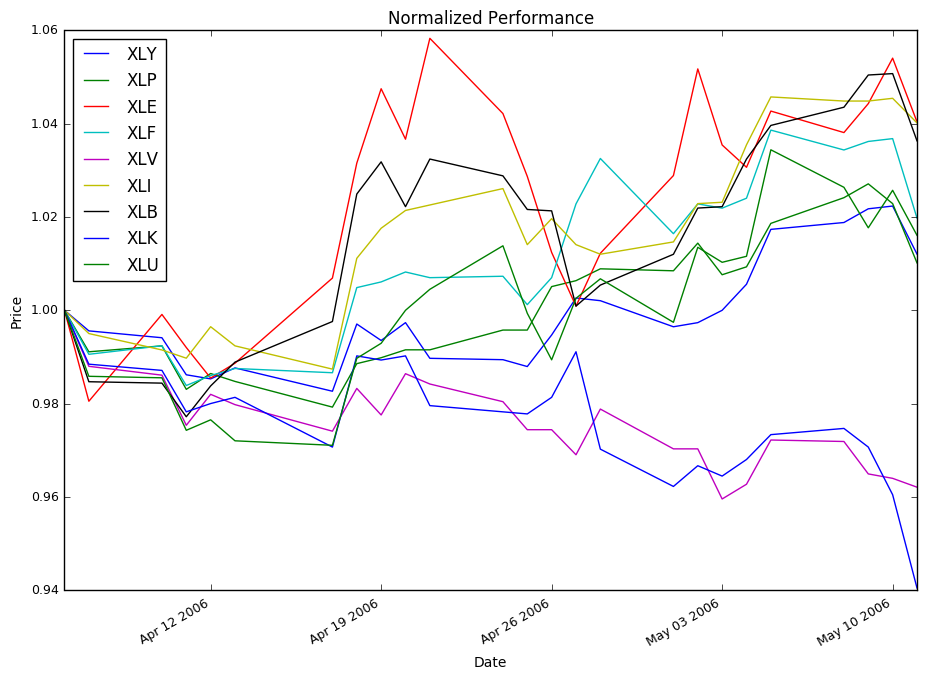

In [21]:
df = test_price
plot_data(normalize_data(df), "train", title="Normalized Performance", test=3)

Let's take a look our test results for the last epoch (found in logs under '2006-04-07') and see how we did.

Our model's total return for the period outperformed the benchmark by 1.3841%. Its Sharpe ratio outperformed the benchmark by 2.53. Let's take a look at the actions that our model chose and see how well it compares to other actions it could have taken (shown in the graph above):

> 2006-04-07 00:00:00 ACTION: 3 (-1.039)  
2006-04-10 00:00:00 ACTION: 3 (-1.024)  
2006-04-11 00:00:00 ACTION: 3 (-1.049)  
2006-04-12 00:00:00 ACTION: 3 (-1.046)  
2006-04-13 00:00:00 ACTION: 3 (-1.044)  
2006-04-17 00:00:00 ACTION: 3 (-1.035)  
2006-04-18 00:00:00 ACTION: 3 (1.008)  
2006-04-19 00:00:00 ACTION: 3 (1.013)  
2006-04-20 00:00:00 ACTION: 3 (1.012)  
2006-04-21 00:00:00 ACTION: 3 (1.017)  
2006-04-24 00:00:00 ACTION: 3 (1.014)  
2006-04-25 00:00:00 ACTION: 3 (1.006)  
2006-04-26 00:00:00 ACTION: 3 (1.003)  
2006-04-27 00:00:00 ACTION: 3 (1.001)  
2006-04-28 00:00:00 ACTION: 3 (1.005)  
2006-05-01 00:00:00 ACTION: 3 (1.006)  
2006-05-02 00:00:00 ACTION: 3 (1.017)  
2006-05-03 00:00:00 ACTION: 3 (1.011)  
2006-05-04 00:00:00 ACTION: 3 (1.013)  
2006-05-05 00:00:00 ACTION: 3 (1.038)  
2006-05-08 00:00:00 ACTION: 3 (1.031)  
2006-05-09 00:00:00 ACTION: 3 (1.041)  
2006-05-10 00:00:00 ACTION: 3 (1.042)    

Once again, our model successfully chose the sector that performed best in the period (Action 3: `'XLE'`). Let's try one last time with another random window.

In [23]:
# Re-initialize and run Q-learning loop on random time window (Same code as above)

# Neural Net Q-Function
# Initialize sequential model
model = Sequential()

# Build first layer
model.add(LSTM(64,
               input_shape=(steps, num_features),
               return_sequences=True,
               stateful=False))
model.add(Dropout(0.50)) # drop inputs to avoid overfitting

# Build second layer
model.add(LSTM(64,
               input_shape=(steps, num_features),
               return_sequences=True,
               stateful=False))
model.add(Dropout(0.50)) # drop inputs to avoid overfitting

# Build third layer
model.add(LSTM(64,
               input_shape=(steps, num_features),
               return_sequences=False,
               stateful=False))
model.add(Dropout(0.50)) # drop inputs to avoid overfitting

# Build fourth layer
model.add(Dense(10, init='lecun_uniform'))
model.add(Activation('linear'))

# Build optimizer and compile
adam = Adam()
model.compile(loss='mse', optimizer=adam)

# Q-Learning loop
# Initialize start time
start_time = timeit.default_timer()

# Initialize learning variables
epochs = 25 # number of passes on the training data
gamma = 0.95 # weight of future rewards
epsilon = 1.25 # measure of randomness for exploration (ten random epochs then constant decrease)
batch_size = 10 # size of training batches for our neural net

# Initialize experience variables
memory = [] # stores training data for neural net in efficient chunks
mem_limit = 20
mem_counter = 0

# Initialize random training window start
window = np.random.randint(201,4000)
print "Window: {}".format(window)

# Initialize testing data
test_data, test_price, test_spy = load_data(window=window, test=True)

# Initialize training data
train_data, price_data, benchmark = load_data(window=window)

# Open file to log portfolio results after epoch (logs folder must exist)
open('logs/master_test_log.txt', 'w').close()
open('logs/master_train_log.txt', 'w').close()

for i in range(epochs):
    # Initialize variables
    state = init_state(train_data)
    port = Portfolio(100000, price_data)
    status = 1
    terminal_state = 0
    time_step = 1
    
    # Open file to log training actions (logs folder must exist)
    open('logs/train_action_log_{}.txt'.format(i+1), 'w').close()
    
    # Train while status = 1
    while status == 1:
        # Run Q-function model on initial state and get rewards for actions
        qval = model.predict(state[0], batch_size=1)
        
        # Using epsilon, add random exporation to the trainer
        # Otherwise find action with Q-function model.
        if random.random() < epsilon:
            action = np.random.randint(1,10)
        else:
            action = (np.argmax(qval))
            
        # Take action and get new state
        new_state, time_step, terminal_state = take_action(state, train_data, action, time_step)
        
        # Get reward
        reward = get_reward(port, price_data, state, new_state, time_step)
        
        # Log date, actions, and reward to text file. (logs folder must exist)
        date = price_data.iloc[time_step - 1].name
        with open('logs/train_action_log_{}.txt'.format(i+1), 'a') as file:
                file.write("{} ACTION: {} ({:.3f})\n".format(date, action, reward))
        
        # If memory not full, add to memory
        if len(memory) < mem_limit:
            memory.append((state, action, reward, new_state))
            state = new_state # set state for next loop
            
        # Otherwise overwrite memory
        else:
            if mem_counter < (mem_limit - 1):
                mem_counter +=1
            else:
                mem_counter = 0
            memory[mem_counter] = (state, action, reward, new_state)
            state = new_state # set state for next loop
            
            # Begin training model on memory experience
            mem_batch = random.sample(memory, batch_size)
            X_train = []
            y_train = []

            for mem in mem_batch:
                # Get Q-values with Q-function
                prior_state, action, reward, next_state = mem
                prior_qval = model.predict(prior_state[0], batch_size=1)
                next_qval = model.predict(next_state[0], batch_size=1)
                
                # Get reward for next state
                next_reward = np.max(next_qval)
                
                # Calculate reward based on gamma, if terminal just use reward
                if terminal_state == 0:
                    reward_update = (reward + (gamma * next_reward))
                else: #terminal state
                    reward_update = reward
                    
                # Get training data together
                y = np.zeros((1,10))
                y[:] = prior_qval[:]
                y[0][action] = reward_update

                X_train.append(prior_state[0]) # Input technical data
                y_train.append(y.reshape(10,)) # Output reward for actions
                
            # Reshape training batch to fit model input
            X_train = np.squeeze(np.array(X_train), axis=(1))
            y_train = np.array(y_train)
            
            # Train model on memory batch
            model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1, verbose=0)

        # update status
        if terminal_state == 1:
            status = 0
            
    # Update epsilon for next epoch
    epsilon -= (1.25/(epochs-1))
            
    # Evaluate epoch results on training data
    cum_ret, sharpe_ratio, cum_spy, sharpe_ratio_spy = port.statistics(benchmark)
    port.plot_results(benchmark, i+1)
    with open('logs/master_train_log.txt'.format(i+1), 'a') as file:
                file.write("Train {}/{}: Relative Return/Sharpe: {:.4%}/{:.2f}\n".format(i+1, epochs,
                                                                                         cum_ret - cum_spy,
                                                                                         sharpe_ratio - sharpe_ratio_spy))
                
    # Evaluate epoch results on testing data
    elapsed = np.round((timeit.default_timer() - start_time)/60, decimals=2)
    cum_ret, sharpe_ratio, cum_spy, sharpe_ratio_spy = evaluate_qlearner(test_data, model, test_price, test_spy, i)
    print "Test {}/{} completed in {:.2f} minutes - Relative Return/Sharpe: {:.4%} / {:.2f}".format(i+1, epochs, elapsed,
                                                                                                    cum_ret - cum_spy,
                                                                                                    sharpe_ratio - \
                                                                                                    sharpe_ratio_spy)
    with open('logs/master_test_log.txt'.format(i+1), 'a') as file:
                file.write("Test {}/{}: Relative Return/Sharpe: {:.4%}/{:.2f}\n".format(i+1, epochs, cum_ret - cum_spy,
                                                                                        sharpe_ratio - sharpe_ratio_spy))
    #print "*"*100
    
elapsed = np.round((timeit.default_timer() - start_time)/60/60, decimals=2)
print "Epochs completed in {:.2f} hours".format(elapsed)

Window: 624
Test 1/25 completed in 0.73 minutes - Relative Return/Sharpe: 0.1360% / 0.28
Test 2/25 completed in 1.05 minutes - Relative Return/Sharpe: -0.2301% / -0.18
Test 3/25 completed in 1.37 minutes - Relative Return/Sharpe: 0.1360% / 0.19
Test 4/25 completed in 1.70 minutes - Relative Return/Sharpe: 0.7281% / 0.59
Test 5/25 completed in 2.02 minutes - Relative Return/Sharpe: 0.3704% / 0.23
Test 6/25 completed in 2.35 minutes - Relative Return/Sharpe: -0.4109% / -0.26
Test 7/25 completed in 2.67 minutes - Relative Return/Sharpe: -0.4109% / -0.26
Test 8/25 completed in 2.99 minutes - Relative Return/Sharpe: -0.4109% / -0.26
Test 9/25 completed in 3.33 minutes - Relative Return/Sharpe: 0.1360% / 0.11
Test 10/25 completed in 3.65 minutes - Relative Return/Sharpe: -0.2301% / 0.06
Test 11/25 completed in 4.01 minutes - Relative Return/Sharpe: -0.2301% / 0.06
Test 12/25 completed in 4.37 minutes - Relative Return/Sharpe: -0.2301% / -0.23
Test 13/25 completed in 4.71 minutes - Relative R

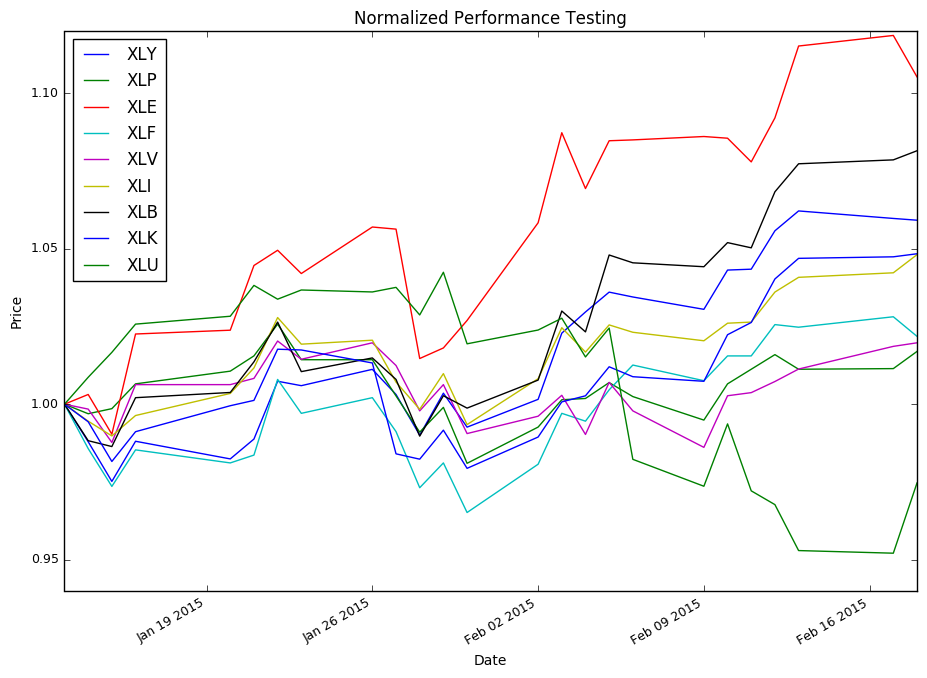

In [27]:
df = test_price
plot_data(normalize_data(df), "train", title="Normalized Performance Testing", test=3)

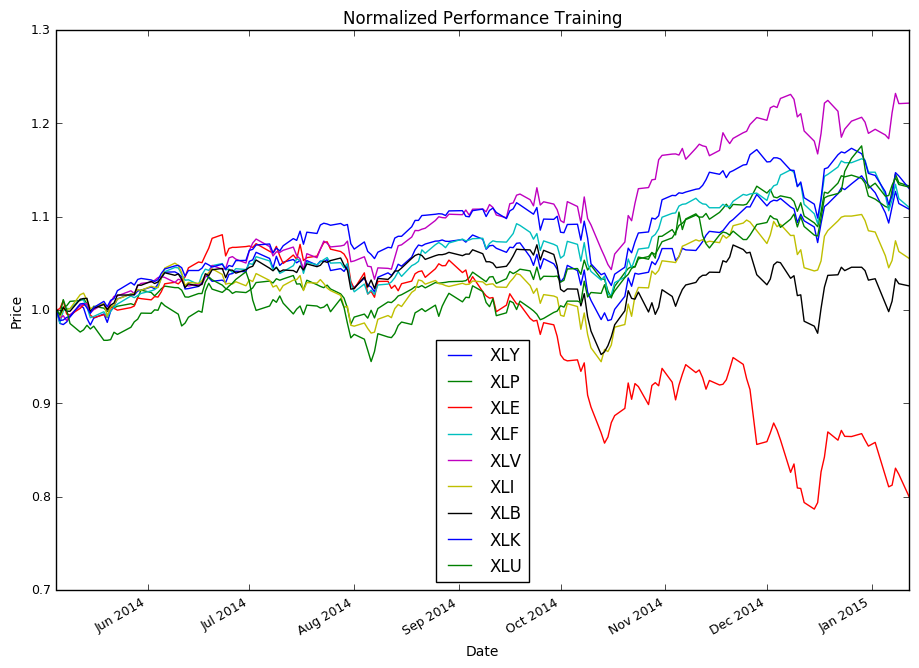

In [28]:
df = price_data
plot_data(normalize_data(df), "train", title="Normalized Performance Training", test=3)

Let's take a look our test results for the last epoch (found in logs under '2015-01-14') and see how we did.

Our model's total return for the period underperformed the benchmark by 0.4109%. Its Sharpe ratio underperformed the benchmark by 0.35. Let's take a look at the actions that our model chose and see how well it compares to other actions it could have taken (shown in the testing graph above):

> 2015-01-14 00:00:00 ACTION: 8 (-1.015)  
2015-01-15 00:00:00 ACTION: 8 (-1.038)  
2015-01-16 00:00:00 ACTION: 7 (1.003)  
2015-01-20 00:00:00 ACTION: 8 (1.003)  
2015-01-21 00:00:00 ACTION: 8 (1.010)  
2015-01-22 00:00:00 ACTION: 5 (1.023)  
2015-01-23 00:00:00 ACTION: 5 (1.017)  
2015-01-26 00:00:00 ACTION: 5 (1.021)  
2015-01-27 00:00:00 ACTION: 5 (1.012)  
2015-01-28 00:00:00 ACTION: 5 (-1.010)  
2015-01-29 00:00:00 ACTION: 7 (1.005)  
2015-01-30 00:00:00 ACTION: 8 (-1.026)  
2015-02-02 00:00:00 ACTION: 7 (1.007)  
2015-02-03 00:00:00 ACTION: 5 (1.018)  
2015-02-04 00:00:00 ACTION: 5 (1.011)  
2015-02-05 00:00:00 ACTION: 5 (1.024)  
2015-02-06 00:00:00 ACTION: 5 (1.017)  
2015-02-09 00:00:00 ACTION: 5 (1.011)  
2015-02-10 00:00:00 ACTION: 5 (1.023)  
2015-02-11 00:00:00 ACTION: 5 (1.026)  
2015-02-12 00:00:00 ACTION: 5 (1.042)  
2015-02-13 00:00:00 ACTION: 5 (1.030)  
2015-02-17 00:00:00 ACTION: 5 (1.032)      

It's pretty clear our model failed to choose the sector that performed best in the period (Action 3: `'XLE'`). Instead, our model didn't seem very confident and switched around between Action 8 and Action 5. Let's look at the training data (shown in the training graph above and see if we can figure out why our model failed to select Action 3.

It quickly becomes clear that Action 3 would have led to terrible results in the training data. Action 3 is the energy sector and this training period coincided with a [huge crash in oil prices](http://www.investopedia.com/ask/answers/030315/why-did-oil-prices-drop-so-much-2014.asp). This probably explains why our model failed to choose correctly.

## Conclusion

We build a Q-learner that could use 175 days of training data to predict the next 25 days of testing data. Our model seemed to be working but then hit a huge snag when it couldn't accurately predict a rise in the energy sector after training on a period that included a crash in the energy sector.

It is possible that with a longer training window, the model would be able to see both bull market and bear market conditions for every sector. When I attempted something similar, the training time would have taken about three days on my single graphics card. Maybe in the future when I can afford better processing power, I can test this Q-learner on larger data sets that include fundamental data.